# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: [https://colab.research.google.com/github/GreatArcStudios/APS360/blob/master/Lab%204/Lab4%20Data%20Imputation.ipynb](https://colab.research.google.com/github/GreatArcStudios/APS360/blob/master/Lab%204/Lab4%20Data%20Imputation.ipynb)

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [175]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df_full = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)
df = df_full

C:\Users\ericz\AppData\Local\Temp\ipykernel_31408\1439901705.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_full = pd.read_csv(


In [176]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [177]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [178]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

So we need to first report the min/max/avg of variables of interest (`["age", "yredu", "capgain", "caploss", "workhr"]`) then normalize them. As in we compute the following for normalization: 

$$
\mathbf{x}_{\text{normalized}} = \frac{\left(\mathbf{x} - \bar{\mathbf{x}}\right)}{\widehat{\sigma}_{\mathbf{x}}}
$$

In [180]:
for variable in ["age", "yredu", "capgain", "caploss", "workhr"]: 
    print(f"{variable} statistics | min: {min(df[variable])}, max: {max(df[variable])}, average: { np.average(df[variable])}")  
    df[variable] = (df[variable] - np.average(df[variable])) / np.std(df[variable])

df.head()

age statistics | min: -1.5822062886564523, max: 3.769612336743166, average: -2.7059150282317012e-17
yredu statistics | min: -3.5296563996401558, max: 2.3008375546552444, average: 1.4718868439857116e-16
capgain statistics | min: -0.14592048355885345, max: 13.394577908462539, average: 1.3093137233379199e-17
caploss statistics | min: -0.21665952703259014, max: 10.593506563264937, average: 1.0169003251257845e-16
workhr statistics | min: -3.1940303099566942, max: 4.742966730361867, average: -1.5493545726165386e-17


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.030671,State-gov,77516,Bachelors,1.134739,Never-married,Adm-clerical,Not-in-family,White,Male,0.148453,-0.21666,-0.035429,United-States
1,0.837109,Self-emp-not-inc,83311,Bachelors,1.134739,Married-civ-spouse,Exec-managerial,Husband,White,Male,-0.145920,-0.21666,-2.222153,United-States
2,-0.042642,Private,215646,HS-grad,-0.420060,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.145920,-0.21666,-0.035429,United-States
3,1.057047,Private,234721,11th,-1.197459,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,-0.145920,-0.21666,-0.035429,United-States
4,-0.775768,Private,338409,Bachelors,1.134739,Married-civ-spouse,Prof-specialty,Wife,Black,Female,-0.145920,-0.21666,-0.035429,Cuba


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [181]:
# hint: you can do something like this in pandas
print("Percentage of women in dataset:", sum(df["sex"] == " Female")/len(df["sex"]) * 100)

Percentage of women in dataset: 33.07945087681583


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [182]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [183]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

To find the number of samples with missing features, we can simply find the length of the `df_with_missing` dataframe. Then similarly to find the percentage of records, we can simply divide that number by the total number of samples in this dataset. 

In [184]:
length_missing = len(df_with_missing)
length_total = len(df)

precentage_missing = length_missing/length_total
print(f"Precentage missing: {round(precentage_missing, 4)*100}% | Records with missing features: {length_missing}")

Precentage missing: 5.66% | Records with missing features: 1843


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [185]:
set(df_not_missing['work'])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [186]:
data = pd.get_dummies(df_not_missing)

In [187]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.030671,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.837109,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,-0.042642,-0.420060,-0.145920,-0.21666,-0.035429,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [188]:
len(data.columns)

57

This number is the length property of the `data.columns` object, which is an iterable, so it has a length property, meaning we can call `len` on it. Note that `data.columns` gets all of the column names of a dataframe. 

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [191]:
datanp = data.values.astype(np.float32)

In [221]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.

    # this is really asking us to retrieve the respective value from 
    # cat_values based on the argmax of the respective subarray of the onehot buffer

    # the first example in the doc string since it is the only 1 in position 6
    # which corresponds to 'State-gov' in cat_values 

    index = np.argmax(onehot)
    feature_values = cat_values[feature]
    return feature_values[index]


In [193]:
# clearly works as expected 
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"), get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov Private


In [194]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [195]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo

# seems like we want to perform the splitting in numpy if we are seeting the seed using numpy 
# so first shuffle the data
# then slice 70%, 15%, and 15% 
data_shuffled = datanp[:]
np.random.shuffle(data_shuffled)
train_end, val_end = int(len(data_shuffled)*0.7), int(len(data_shuffled)*0.85) # make sure to floor them
data_train, data_val, data_test = data_shuffled[:train_end], data_shuffled[train_end: val_end], data_shuffled[val_end: ]
print(len(data_train), len(data_val), len(data_test))

21502 4608 4608


As we can see from the block above, the train set has 21502 samples, 4608 samples in the validation set, and finally 4608 samples in the test set. 

In [196]:
# create the Pytorch datasets and dataloaders for training 
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

train_set = TensorDataset(torch.from_numpy(data_train))
val_set = TensorDataset(torch.from_numpy(data_val))
test_set = TensorDataset(torch.from_numpy(data_test))

train_loader, val_loader, test_loader = DataLoader(train_set, 128), DataLoader(val_set, len(data_val)), DataLoader(test_set, len(data_val))

## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [58]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(57, 47),
            nn.Linear(47, 37),
            nn.Linear(37, 30),
            nn.Linear(30, 20),
            nn.Linear(20, 12),
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 20),
            nn.Linear(20, 28),
            nn.Linear(28, 40),
            nn.Linear(40, 50),
            nn.Linear(50, 57),
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The sigmoid function allow us to output values between 0 and 1 (on the interval $[0, ~ 1]$), and since we are creating an imputation model for categorical features that are learning the one-hot encodings that are either 0 and 1, we need the use the sigmoid function to "clamp" our predictions to be between 0 and 1. Note that while we cannot have exactly 0 or 1 due to the continuous nature of this model or some kind of discretization, we can have the model output on the range of $[0, ~ 1]$. 

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [60]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records


def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))


def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4, val_epochs=10, weight_decay=1e-4, acc_func=None, use_cuda=True, model_path_prefix="./models/", plot_acc=False):
    """ Training loop. You should update this."""
    torch.manual_seed(42)

    # determine if CUDA is available and set Tensor core flags
    if use_cuda and torch.cuda.is_available():
        dev = "cuda:0"
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    else:
        print("CUDA unavailable, training on CPU")
        dev = "CPU"
    device = torch.device(dev)
    model = model.to(device)
    val_set = None

    best_val_loss = float('inf')

    for _, batch in enumerate(valid_loader):
        val_set = batch[0].to(device)
        summary(model, input_data=val_set, verbose=2, device=device)

    loss_dict = {"config": f"Epochs: {num_epochs}, Lr: {learning_rate}",
                 "epochs": num_epochs,
                 "train_loss": [], "val_loss": [],
                 "train_acc": [], "val_acc": []}

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        train_loss = 0.0
        batches = 0
        
        for _, data in enumerate(train_loader):
            data = data[0].to(device)
            # zero out one categorical feature
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)
            train_loss += loss
            batches += 1
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= batches

        if epoch % val_epochs == 0:
            with torch.no_grad():
                val_acc = 0.0
                train_acc = 0.0
                preds = model(val_set)
                val_loss = criterion(preds, val_set)
                print(
                    f"epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")
                if plot_acc:
                    val_acc = acc_func(model, valid_loader)
                    train_acc = acc_func(model, train_loader)
                    print(
                        f"epoch: {epoch}, train_acc: {train_acc}, val_acc: {val_acc}")

                loss_dict["train_loss"].append(train_loss)
                loss_dict["val_loss"].append(val_loss)
                loss_dict["train_acc"].append(train_acc)
                loss_dict["val_acc"].append(val_acc)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), model_path_prefix +
                               f"valloss-{torch.round(best_val_loss, decimals=4)}-lr_{learning_rate}-epoch_num_{epoch}.mdlckpt")

    return model, loss_dict


In [61]:
FCAutoEncoder = AutoEncoder()
model, loss_dict = train(FCAutoEncoder, train_loader, val_loader, num_epochs=100, acc_func=get_accuracy, plot_acc=True)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4608, 57]                --
├─Sequential: 1-1                        [4608, 12]                --
│    └─0.weight                                                    ├─3,249
│    └─0.bias                                                      ├─57
│    └─1.weight                                                    ├─2,679
│    └─1.bias                                                      ├─47
│    └─2.weight                                                    ├─1,739
│    └─2.bias                                                      ├─37
│    └─3.weight                                                    ├─1,110
│    └─3.bias                                                      ├─30
│    └─4.weight                                                    ├─600
│    └─4.bias                                                      ├─20
│    └─5.weight                                     

In [62]:
from matplotlib import pyplot as plt 
def plot_acc_curves(loss_dict):
    plt.title(f"{loss_dict['config']}")
    n = len([value for value in loss_dict["train_acc"]])
    plt.plot(range(1,n+1), [value for value in  loss_dict["train_acc"]], label="Train Accuracy")
    plt.plot(range(1,n+1), [value for value in  loss_dict["val_acc"]], label="Validation Accuracy")
    plt.xlabel(f"{loss_dict['epochs']} times Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def plot_loss_curves(loss_dict):
    plt.title(f"{loss_dict['config']}")
    n = len([value.cpu().data.numpy() for value in loss_dict["train_loss"]])
    plt.plot(range(1,n+1), [value.cpu().data.numpy() for value in loss_dict["train_loss"]], label="Train Loss")
    plt.plot(range(1,n+1), [value.cpu().data.numpy() for value in loss_dict["val_loss"]], label="Validation Loss")
    plt.xlabel(f"{loss_dict['epochs']} times Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

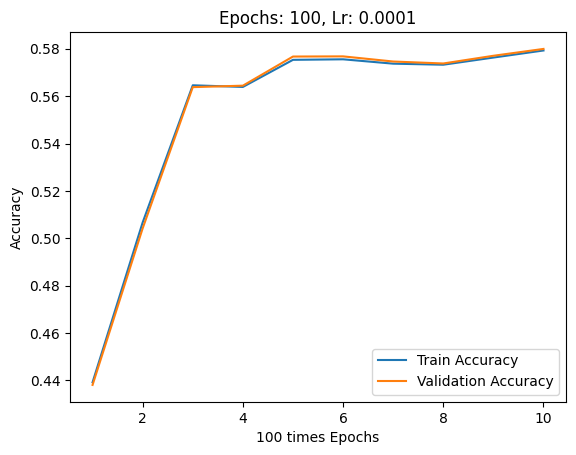

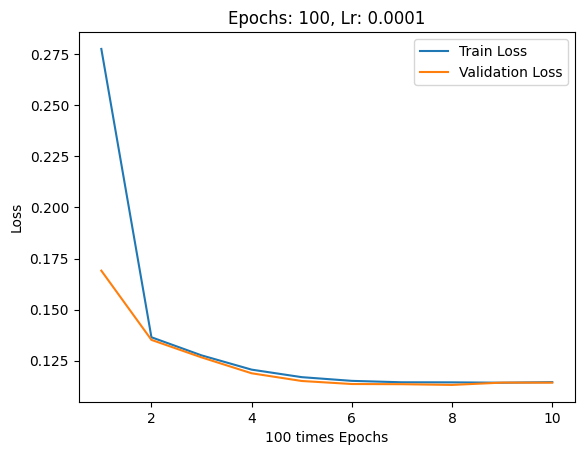

In [63]:
plot_acc_curves(loss_dict)
plot_loss_curves(loss_dict)

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [135]:
def get_accuracy(model, data_loader, baseline_model = False):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            item = item[0]
            inp = item.detach().numpy()
            if baseline_model: 
                missing_cols = set(range(cat_index[col], cat_index[col] + len(cat_values[col])))
                out = model(zero_out_feature(item.clone(), col), missing_cols).detach().numpy()
            else: 
                out = model(zero_out_feature(item.clone(), col).to("cuda:0")).cpu().detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [64]:
FCAutoEncoder = AutoEncoder()
model, loss_dict = train(FCAutoEncoder, train_loader, val_loader, num_epochs=120, learning_rate=4e-4, acc_func=get_accuracy, plot_acc=True)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4608, 57]                --
├─Sequential: 1-1                        [4608, 12]                --
│    └─0.weight                                                    ├─3,249
│    └─0.bias                                                      ├─57
│    └─1.weight                                                    ├─2,679
│    └─1.bias                                                      ├─47
│    └─2.weight                                                    ├─1,739
│    └─2.bias                                                      ├─37
│    └─3.weight                                                    ├─1,110
│    └─3.bias                                                      ├─30
│    └─4.weight                                                    ├─600
│    └─4.bias                                                      ├─20
│    └─5.weight                                     

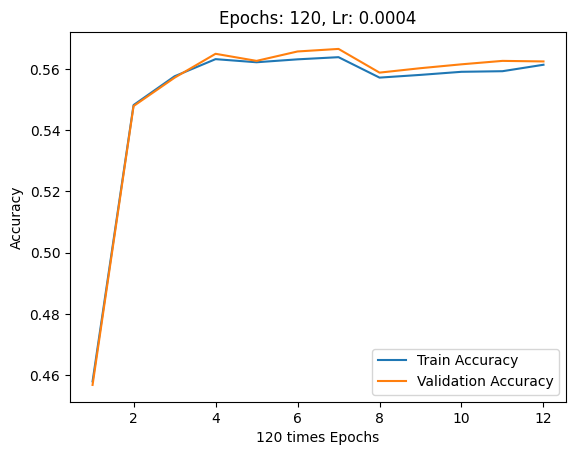

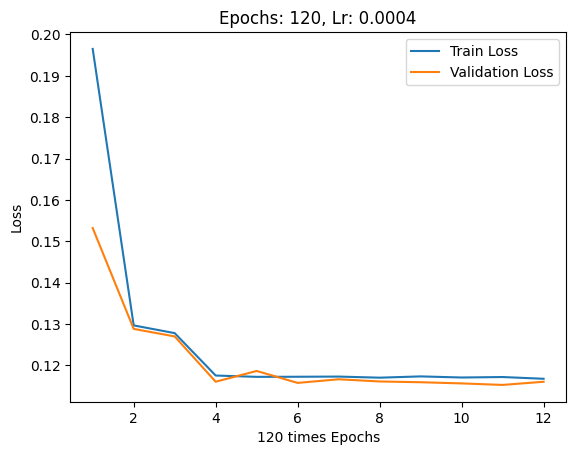

In [66]:
plot_acc_curves(loss_dict)
plot_loss_curves(loss_dict)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [69]:
FCAutoEncoder = AutoEncoder()
model, loss_dict = train(FCAutoEncoder, train_loader, val_loader, num_epochs=200, learning_rate=2e-3, weight_decay=1e-5, acc_func=get_accuracy, plot_acc=True)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4608, 57]                --
├─Sequential: 1-1                        [4608, 12]                --
│    └─0.weight                                                    ├─3,249
│    └─0.bias                                                      ├─57
│    └─1.weight                                                    ├─2,679
│    └─1.bias                                                      ├─47
│    └─2.weight                                                    ├─1,739
│    └─2.bias                                                      ├─37
│    └─3.weight                                                    ├─1,110
│    └─3.bias                                                      ├─30
│    └─4.weight                                                    ├─600
│    └─4.bias                                                      ├─20
│    └─5.weight                                     

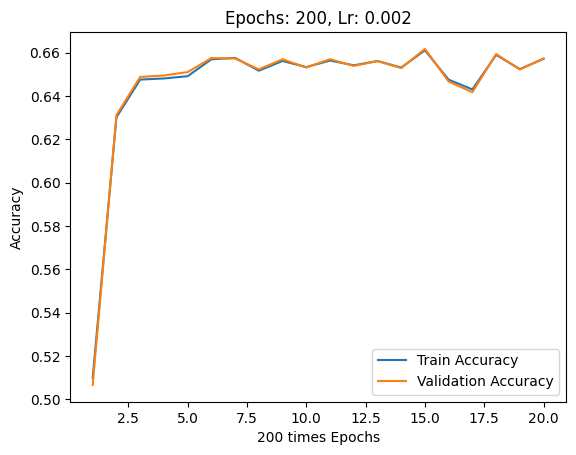

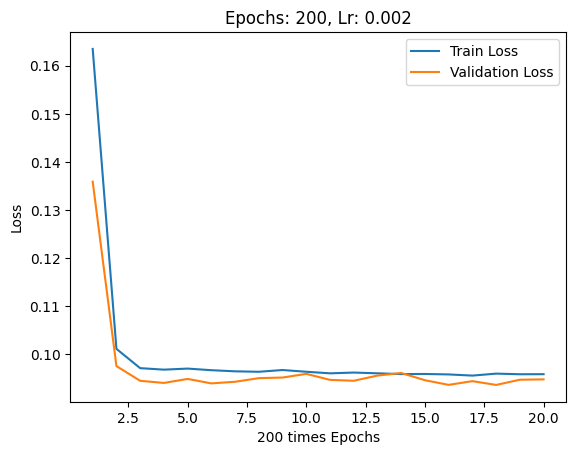

In [70]:
plot_acc_curves(loss_dict)
plot_loss_curves(loss_dict)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

We will try the four following sets of hyperparameters: 
1. A high learning rate with a high weight decay 
2. A high learning rate with a lower weight decay
3. A lower learning rate with a high weight decay
4. A lower learning rate with a lower weight decay
5. Based on the above, we will try a larger epoch count 

This will essentially allow for us to perform a grid search over the available hyperparameters that I have coded. And then choose the combination, e.g., high learning rate and high weight decay, using a binary search strategy. This will be the main thinking for model 5 where we select the hyperparameters that we train over more epochs. 

In [71]:
# high learning rate, high WD
FCAutoEncoder = AutoEncoder()
model, loss_dict = train(FCAutoEncoder, train_loader, val_loader, num_epochs=100, learning_rate=6e-2, weight_decay=1e-3, acc_func=get_accuracy, plot_acc=True)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4608, 57]                --
├─Sequential: 1-1                        [4608, 12]                --
│    └─0.weight                                                    ├─3,249
│    └─0.bias                                                      ├─57
│    └─1.weight                                                    ├─2,679
│    └─1.bias                                                      ├─47
│    └─2.weight                                                    ├─1,739
│    └─2.bias                                                      ├─37
│    └─3.weight                                                    ├─1,110
│    └─3.bias                                                      ├─30
│    └─4.weight                                                    ├─600
│    └─4.bias                                                      ├─20
│    └─5.weight                                     

In [75]:
# high learning rate, low WD
FCAutoEncoder = AutoEncoder()
model, loss_dict = train(FCAutoEncoder, train_loader, val_loader, num_epochs=100, learning_rate=6e-2, weight_decay=1e-5, acc_func=get_accuracy, plot_acc=True)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4608, 57]                --
├─Sequential: 1-1                        [4608, 12]                --
│    └─0.weight                                                    ├─3,249
│    └─0.bias                                                      ├─57
│    └─1.weight                                                    ├─2,679
│    └─1.bias                                                      ├─47
│    └─2.weight                                                    ├─1,739
│    └─2.bias                                                      ├─37
│    └─3.weight                                                    ├─1,110
│    └─3.bias                                                      ├─30
│    └─4.weight                                                    ├─600
│    └─4.bias                                                      ├─20
│    └─5.weight                                     

In [73]:
# lower learning rate, high WD
FCAutoEncoder = AutoEncoder()
model, loss_dict = train(FCAutoEncoder, train_loader, val_loader, num_epochs=100, learning_rate=2e-4, weight_decay=1e-3, acc_func=get_accuracy, plot_acc=True)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4608, 57]                --
├─Sequential: 1-1                        [4608, 12]                --
│    └─0.weight                                                    ├─3,249
│    └─0.bias                                                      ├─57
│    └─1.weight                                                    ├─2,679
│    └─1.bias                                                      ├─47
│    └─2.weight                                                    ├─1,739
│    └─2.bias                                                      ├─37
│    └─3.weight                                                    ├─1,110
│    └─3.bias                                                      ├─30
│    └─4.weight                                                    ├─600
│    └─4.bias                                                      ├─20
│    └─5.weight                                     

In [74]:
# lower learning rate, low WD
FCAutoEncoder = AutoEncoder()
model, loss_dict = train(FCAutoEncoder, train_loader, val_loader, num_epochs=100, learning_rate=2e-4, weight_decay=1e-5, acc_func=get_accuracy, plot_acc=True)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4608, 57]                --
├─Sequential: 1-1                        [4608, 12]                --
│    └─0.weight                                                    ├─3,249
│    └─0.bias                                                      ├─57
│    └─1.weight                                                    ├─2,679
│    └─1.bias                                                      ├─47
│    └─2.weight                                                    ├─1,739
│    └─2.bias                                                      ├─37
│    └─3.weight                                                    ├─1,110
│    └─3.bias                                                      ├─30
│    └─4.weight                                                    ├─600
│    └─4.bias                                                      ├─20
│    └─5.weight                                     

From the 4 models above (4 choices of hyperparameters), we can see that having a lower learning rate with a lower weight decay performed the best, scoring almost 64% accuracy on the validation set. The lowest performing set of hyperparameters was the one with the high learning rate and lower weight decay. So from that view, it seems that for the 5th model, we should choose a set of hyperparameters that is lower on the learning rate and lower on the weight decay. Since we are trying to train the model for longer, we could maintain a similar decay parameter in order to help regularize the model in later epochs. Training the model longer could help the model learn more, i.e., work its way through harder to optimize surfaces, which may be needed with a lower learning rate. 

In [81]:
# model 5
FCAutoEncoder = AutoEncoder()
model, loss_dict = train(FCAutoEncoder, train_loader, val_loader, num_epochs=500, learning_rate=1.8e-4, weight_decay=1e-5, acc_func=get_accuracy, plot_acc=True)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [4608, 57]                --
├─Sequential: 1-1                        [4608, 12]                --
│    └─0.weight                                                    ├─3,249
│    └─0.bias                                                      ├─57
│    └─1.weight                                                    ├─2,679
│    └─1.bias                                                      ├─47
│    └─2.weight                                                    ├─1,739
│    └─2.bias                                                      ├─37
│    └─3.weight                                                    ├─1,110
│    └─3.bias                                                      ├─30
│    └─4.weight                                                    ├─600
│    └─4.bias                                                      ├─20
│    └─5.weight                                     

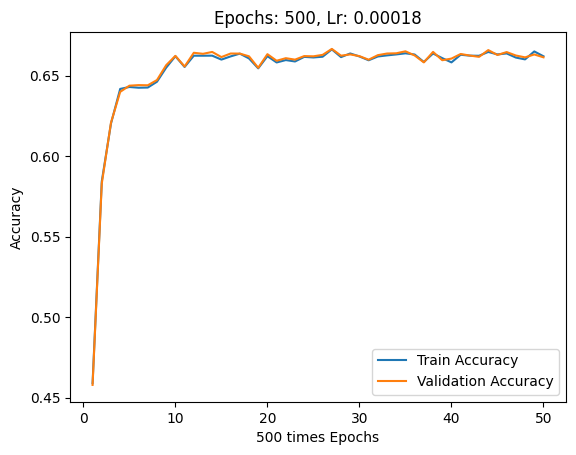

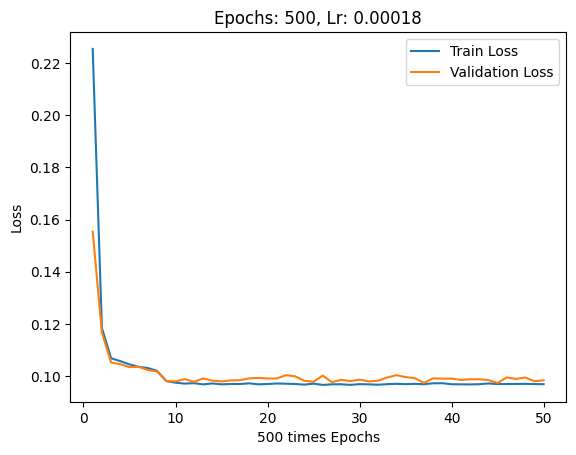

In [82]:
plot_acc_curves(loss_dict)
plot_loss_curves(loss_dict)

As the above plots show, the final set of hyperparameters improve upon the previous ones, and while the improvement isn't large, it is still a few percent better in terms of validation accuracy which is nice. 

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [197]:
get_accuracy(model, test_loader)

0.6646412037037037

So the autoencoder scores a 66.5% accuracy on the test set, which is consistent with the accuracy scores for the train and validation sets. 

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [137]:
# loop over columns of data_train 
# find the most common values per column 
# impute values for each features 
# this is a bit weird, but I essentially 
# wrapped the baseline model in a pytorch model 
# it has better compatibility with the get_accuracy function 
categorical_features = pd.get_dummies(df_not_missing[catcols]).values.astype(np.int64)
# most common values of one-hot encoded categorical features
most_common = [np.argmax(np.bincount(feature)) for feature in categorical_features.T] 

# need a mapping between the actual feature vector that includes contin features 
# gets the categorical feature indexes 
cat_features_indexes = [(cat_index[feature], cat_index[feature] + len(cat_values[feature])) for feature in catcols]
# a mapping from cat_features_indexes to the most_common list
index_mapping = {}
curr_ptr = 0 
for i in range(len(catcols)):
    # has start and finish 
    feature_indexes = cat_features_indexes[i]
    length = feature_indexes[1] - feature_indexes[0]
    most_common_subset = most_common[curr_ptr : curr_ptr + length] 

    # store the respective values into the dict    
    for j in range(length): 
        index_mapping[j+feature_indexes[0]] = most_common_subset[j]

    curr_ptr += length

class BaselineModel(nn.Module): 
    def __init__(self, index_mapping): 
        super(BaselineModel, self).__init__()
        self.most_common = index_mapping

    def forward(self, x, missing_indexes): 
        output = []
        for row in x:
            row_preds = []
            for i in range(len(row)): 
                if i in self.most_common: 
                    pred = self.most_common[i]
                    # if we are supposed to predict these features
                    if i in missing_indexes:
                        row_preds.append(pred)
                    else: 
                        row_preds.append(row[i])
                else: 
                    row_preds.append(row[i])
            output.append(row_preds)
        output = torch.from_numpy(np.array(output))
        return output

In [136]:
baseline_model= BaselineModel(index_mapping)
get_accuracy(baseline_model, test_loader, True)

0.35366030092592593

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy from the autoencoder is roughly 1.9 times as good as the test accuracy from the baseline model. In particular, the baseline model achieved approximately 35.4% test set accuracy, while the autoencoder achieved a test accuracy of approximately 66.5%. 

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

Putting the data back into a pandas dataframe to get the column (feature) names, we have:

In [198]:
test_df = pd.DataFrame(data_test, columns=list(data.columns))
test_df.iloc[0]

age                                1.936798
yredu                              1.134739
capgain                            0.764416
caploss                           -0.216660
workhr                            -0.035429
work_ Federal-gov                  0.000000
work_ Local-gov                    0.000000
work_ Private                      1.000000
work_ Self-emp-inc                 0.000000
work_ Self-emp-not-inc             0.000000
work_ State-gov                    0.000000
work_ Without-pay                  0.000000
marriage_ Divorced                 1.000000
marriage_ Married-AF-spouse        0.000000
marriage_ Married-civ-spouse       0.000000
marriage_ Married-spouse-absent    0.000000
marriage_ Never-married            0.000000
marriage_ Separated                0.000000
marriage_ Widowed                  0.000000
occupation_ Adm-clerical           0.000000
occupation_ Armed-Forces           0.000000
occupation_ Craft-repair           0.000000
occupation_ Exec-managerial     

It is somewhat predictable about the level of education that this person has. In particular, the `occupation_*` features are fairly good proxies of the education level since those columns are quite descriptive of the occupation, and most occupations have certain levels of education required. Further, other features like `yredu` are also directly related to the education level, e.g., those with a PhD would have a much higher normalized value for `yredu` than anyone else. While the capital gains and losses are not directly indicative of education level, they can be informative, on some level, of education since learning math/economics could help you in an area that would net you capital gains (e.g., investments). Finally, the `work_*` features can be informative in certain cases too if the person works in certain sectors, e.g., the government since some of those positions require some level of education, e.g., certain bureaucratic positions requires at least a bachelors. 

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [218]:
person_of_interest_edu_zerod = torch.from_numpy(zero_out_feature(data_test[:], "edu")[0])
out = model(person_of_interest_edu_zerod.to("cuda:0")).cpu().detach().numpy()
data_frame_cols = list(data.columns)
out_df = pd.DataFrame(out.reshape(1, -1), columns=data_frame_cols)
out_df.filter(regex="edu_*")

,yredu,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college
0,0.999998,0.014633,0.014967,0.007034,0.000408,0.001515,0.019362,0.007476,0.047725,0.053316,0.999989,0.026379,3.703797e-19,0.110362,1.199807e-08,0.028891,0.194092


In [219]:
get_feature(out, "edu")

'Bachelors'

As we can see the autoencoder output predicts correctly that this person has a Bachelor's degree since they had the highest score of `edu_bachelors`. Further, the `get_feature` function also outputs "Bachelors" provided the model predictions. 

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [226]:
person_of_interest_edu_zerod = torch.from_numpy(zero_out_feature(data_test[:], "edu")[0]).reshape(1, -1)
missing_cols = set(range(cat_index["edu"], cat_index["edu"] + len(cat_values["edu"])))
out_baseline = baseline_model(person_of_interest_edu_zerod, missing_cols).detach().numpy()
data_frame_cols = list(data.columns)
out_baseline_df = pd.DataFrame(out_baseline, columns=data_frame_cols)
out_baseline_df.filter(regex="edu_*")

,yredu,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college
0,1.134739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
get_feature(out_baseline.reshape(-1, 1), "edu")

'10th'

The baseline model predicts an education level of 10th grade as indicated by the `get_feature` call shown in the above code cell, which not correct. 